In [1]:
!pip install -r requirements.txt

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image, ImageDraw, ImageColor
from skimage.feature import canny
from imageio import imread
from skimage.color import rgb2gray
from skimage.filters import gaussian, try_all_threshold, threshold_otsu, threshold_mean
from skimage.morphology import binary_opening, binary_closing
from skimage.measure import regionprops
from skimage import measure
from scipy import ndimage as ndi
from scipy.ndimage import rotate

In [2]:
ITEMS_PATH = "./items"
DATASET_PATH = "./test_input/images"

# Обработка фотографий с отдельными предметами

In [3]:
# посмотрим на разные методы бинаризации изображения
# как и ожидалось, бинаризация Оцу проявляет себя неплохо в сравнении с другими, попробуем поработать с ней
for img_path in ["corrector.jpg", "key.jpg"]:
    img = imread(os.path.join(ITEMS_PATH, img_path))
    fig, ax = try_all_threshold(rgb2gray(img), figsize=(15, 15), verbose=False)
    print(img_path)
    plt.show()

## Выбор компоненты, соответствующей объекту

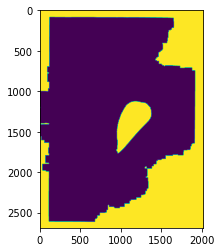

In [4]:
img_path = os.path.join(ITEMS_PATH, "corrector.jpg")
img = imread(img_path)
img = cv2.resize(img, (int(img.shape[1] / 1.5), int(img.shape[0] / 1.5)))

img_blur_gray = rgb2gray(gaussian(img, sigma=1.5, channel_axis=True))
# бинаризация изображения
threshold_img = threshold_otsu(img_blur_gray)
result_image = img_blur_gray <= threshold_img
# морфологические операции для улучшения полученной маски
result_image = binary_opening(result_image, footprint=np.ones((12, 12)))
result_image = binary_closing(result_image, footprint=np.ones((60, 60)))
plt.imshow(result_image)
plt.show()

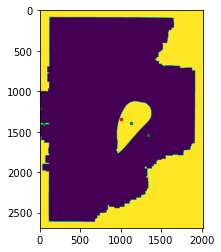

In [5]:
# на маске присутсвует много лишних компонент связности, попробуем отобрать нужную нам, используя то, что объект расположен в центре изображения
labels = measure.label(result_image)
props = regionprops(labels)
# посмотрим на центроиды всех компонент связности
plt.imshow(result_image)
center = (img.shape[0] / 2, img.shape[1] / 2)
plt.plot(center[1], center[0], '.r', markersize=5)
for prop in props:
    plt.plot(prop.centroid[1], prop.centroid[0], '.g', markersize=5)
plt.show()

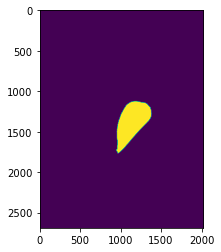

In [6]:
# выбираем компоненту, центроид которой расположен наиболее близко к центру (не рассматриваем компоненту стола)
dist = np.array([pow(center[0] - p.centroid[0], 2) + pow(center[1] - p.centroid[1], 2) for p in props if p.bbox[0] > 0])
mask_id = dist.argmin()
mask = (labels == (mask_id + 2))
plt.imshow(mask)
plt.show()

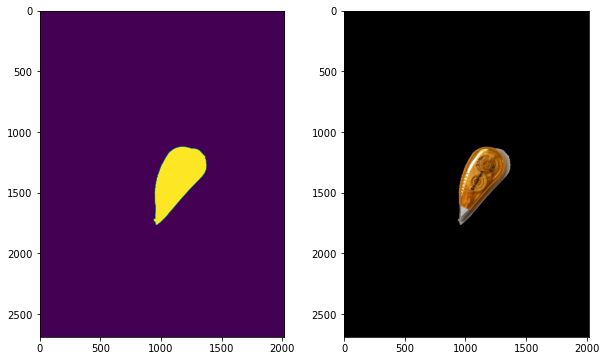

In [7]:
# еще раз закроем дыры в маске
mask = ndi.binary_fill_holes(mask)

# посмотрим, насколько хорошо с помощью полученной маски вырезается объект
visMask = (mask * 255).astype("uint8")
result_image = cv2.bitwise_and(img, img, mask=visMask)

ig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(mask)
ax[1].imshow(result_image)
plt.show()

In [8]:
# вынесем полученную последовательность действий в отдельную функцию
def process_object_img(img_path: str):
    img = imread(img_path)
    # предобработка изображения
    img = cv2.resize(img, (int(img.shape[1] / 1.5), int(img.shape[0] / 1.5)))
    img_blur_gray = rgb2gray(gaussian(img, sigma=1.5, channel_axis=True))
    # бинаризация изображения
    threshold_img = threshold_otsu(img_blur_gray)
    result_image = img_blur_gray <= threshold_img
    
    # морфологические операции для улучшения полученной маски
    # используем то, что мы заранее знаем возможные предметы, чтобы улучшить распознавание
    img_basename = os.path.basename(img_path)
    if img_basename == "corrector.jpg":
        result_image = binary_opening(result_image, footprint=np.ones((12, 12)))
        result_image = binary_closing(result_image, footprint=np.ones((60, 60)))
    elif img_basename == "perfume.jpg":
        result_image = binary_closing(result_image, footprint=np.ones((50, 50)))
        result_image = binary_opening(result_image, footprint=np.ones((22, 22)))
    elif img_basename == "gum.jpg":
        result_image = binary_closing(result_image, footprint=np.ones((27, 27)))
        result_image = binary_opening(result_image, footprint=np.ones((3, 3)))
        result_image = binary_closing(result_image, footprint=np.ones((5, 5)))
    elif img_basename in ["key.jpg", "cream.jpg", "card.jpg"]:
        result_image = binary_opening(result_image, footprint=np.ones((1, 1)))
        result_image = binary_closing(result_image, footprint=np.ones((40, 40)))
        result_image = binary_opening(result_image, footprint=np.ones((1, 1)))
    else:
        result_image = binary_opening(result_image, footprint=np.ones((10, 10)))
        result_image = binary_closing(result_image, footprint=np.ones((50, 50)))
        
    # попробуем отобрать нужную компоненту связности, используя то, что объект расположен в центре изображения
    labels = measure.label(result_image)
    props = regionprops(labels)
    center = (img.shape[0] / 2, img.shape[1] / 2)
    # выбираем компоненту, центроид которой расположен наиболее близко к центру (не рассматриваем компоненту стола)
    dist = np.array([pow(center[0] - p.centroid[0], 2) + pow(center[1] - p.centroid[1], 2) for p in props if p.bbox[0] > 0])
    mask_id = dist.argmin()
    mask = (labels == (mask_id + 2))
    # еще раз закроем дыры в маске
    mask = ndi.binary_fill_holes(mask)
    
    # получим из булевой матрицы изображение и обрежем его по баундинг боксу предмета
    mask_img = (mask * 255).astype("uint8")
    y1, x1, y2, x2 = props[mask_id + 1].bbox
    # вернем маску и обрезанное изображение предмета 
    result_image = img[y1-40:y2+40, x1-40:x2+40]
    vis_mask = mask_img[y1-40:y2+40, x1-40:x2+40]
    return result_image, vis_mask

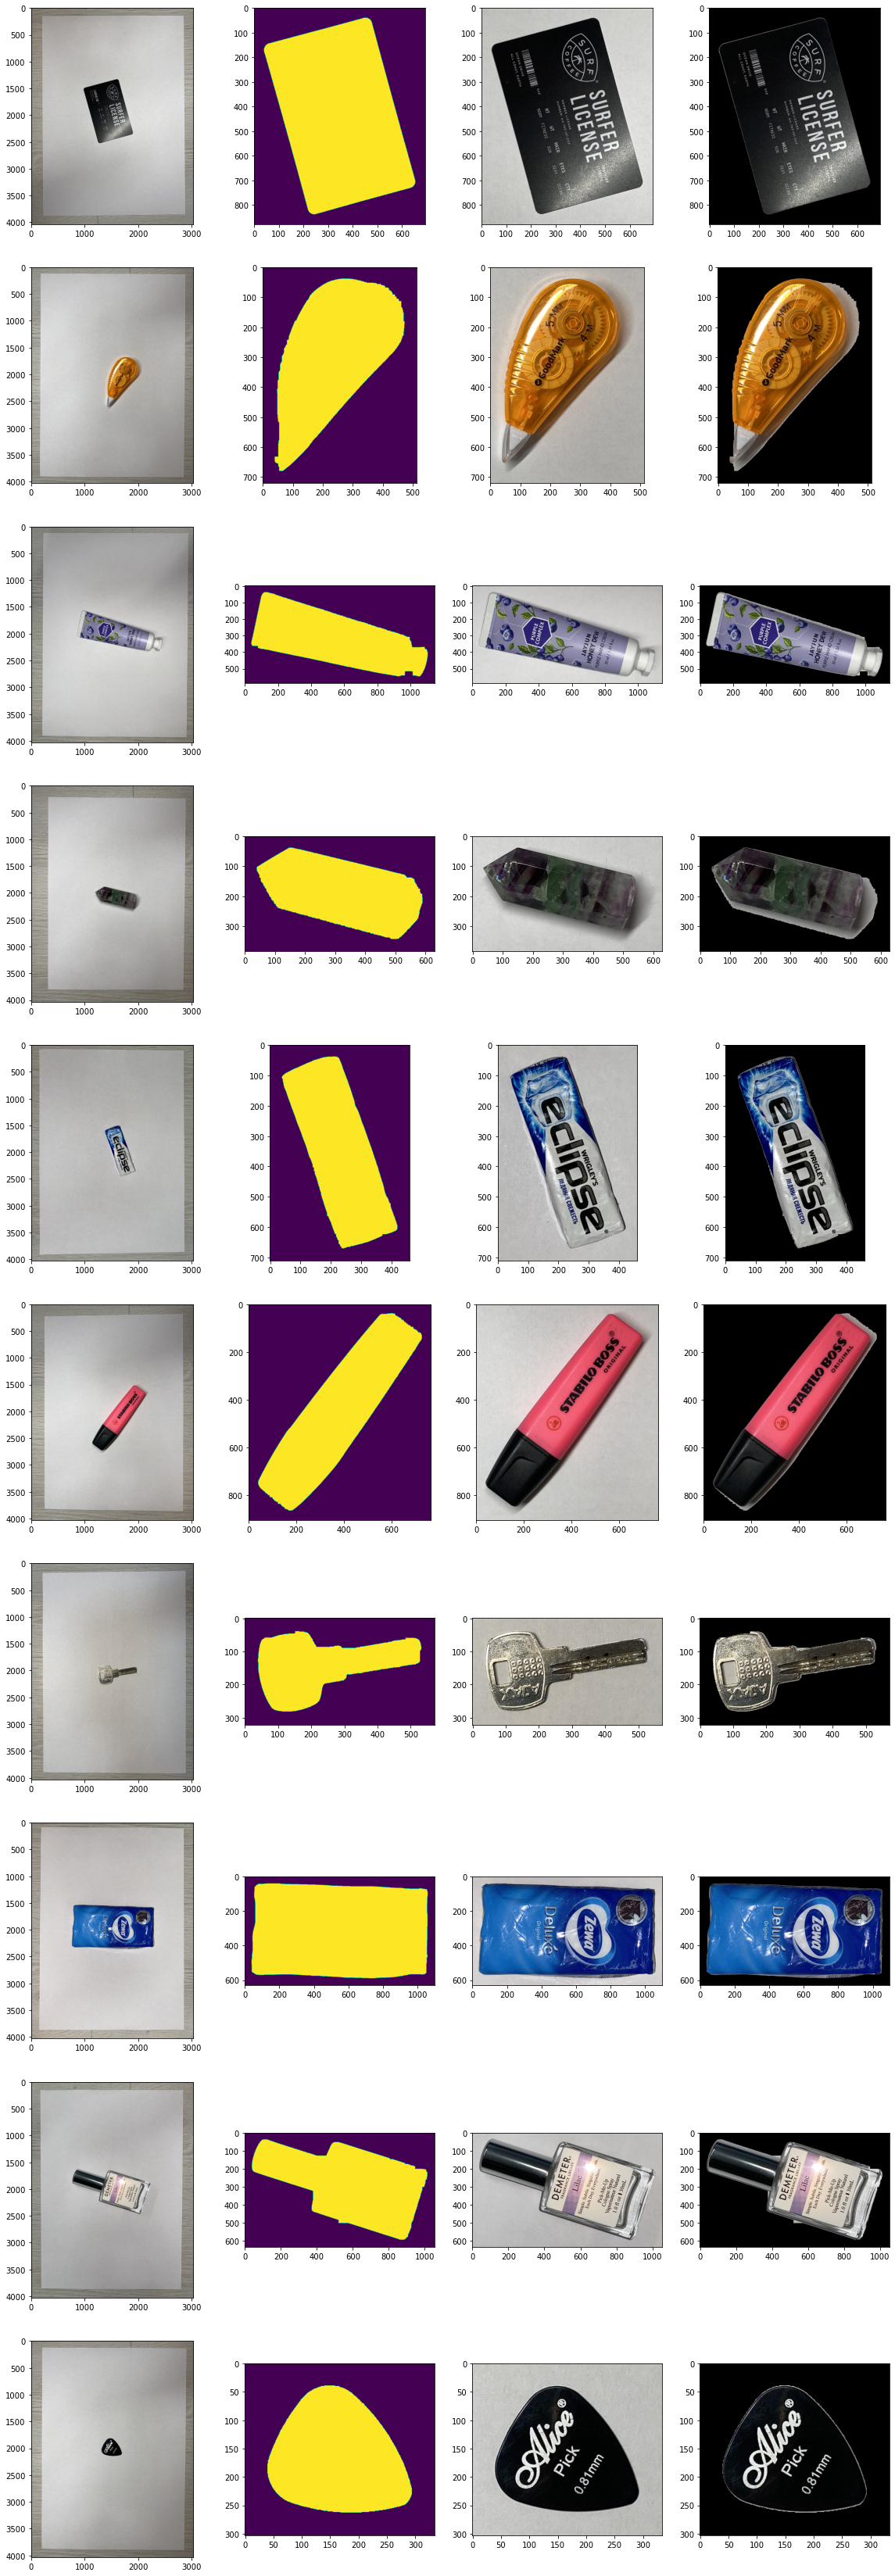

In [3]:
# добавим функцию в библиотеку и посмотрим результат ее работы на всех объектах
from intelligent_placer_lib.modules import object_data_preprocessing

fig, ax = plt.subplots(10, 4, figsize=(20, 60))
i = 0
for img_name in os.listdir(ITEMS_PATH):
    if not img_name == "background.jpg":
        img_path = os.path.join(ITEMS_PATH, img_name)
        result_image, mask = object_data_preprocessing.process_object_img(img_path)
        
        # сохраним полученные маски и обрезанные изображения объектов для дальнейшего использования
        cv2.imwrite(os.path.join("./masks", img_name), cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join("./masks", "mask_" + img_name), mask)

        ax.flatten()[i].imshow(imread(img_path))
        ax.flatten()[i + 1].imshow(mask)
        ax.flatten()[i + 2].imshow(result_image)
        ax.flatten()[i + 3].imshow(cv2.bitwise_and(result_image, result_image, mask=mask))      
        i += 4
plt.show()

In [9]:
MASKS_PATH = "./masks"

# Работа с тестовыми данными

## Получение бинарных масок отдельных предметов

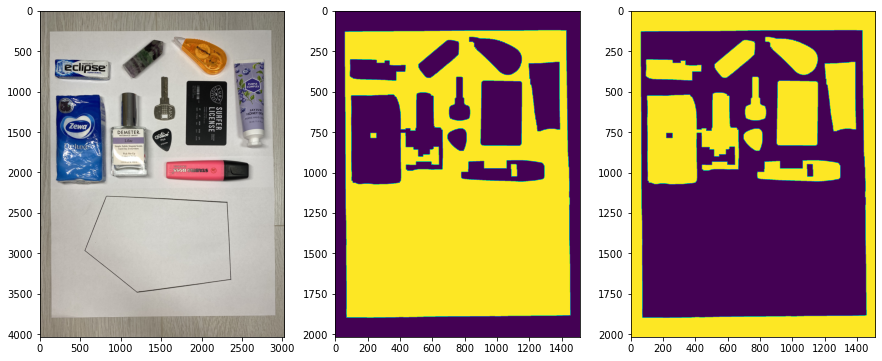

In [10]:
img_path = os.path.join(DATASET_PATH, "23.jpg")
img = imread(img_path)

# предобработка изображения
img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)))
img_blur_gray = rgb2gray(gaussian(img, sigma=1.5, channel_axis=True))

# бинаризуем изображение, получим компоненту соответствующую листу 
# с помощью морфологических операций добьемся закрашивания границ многоугольника
threshold_img = threshold_otsu(img_blur_gray)
mask_sheet = img_blur_gray >= threshold_img

mask_sheet = binary_opening(mask_sheet, footprint=np.ones((30, 30)))
visMask = (mask_sheet * 255).astype("uint8")
mask_sheet = cv2.bitwise_and(img_blur_gray, img_blur_gray, mask=visMask)
mask_sheet = binary_closing(mask_sheet, footprint=np.ones((20, 20)))
mask_image = ~mask_sheet

ig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(imread(img_path))
ax[1].imshow(mask_sheet)
ax[2].imshow(mask_image)
plt.show()

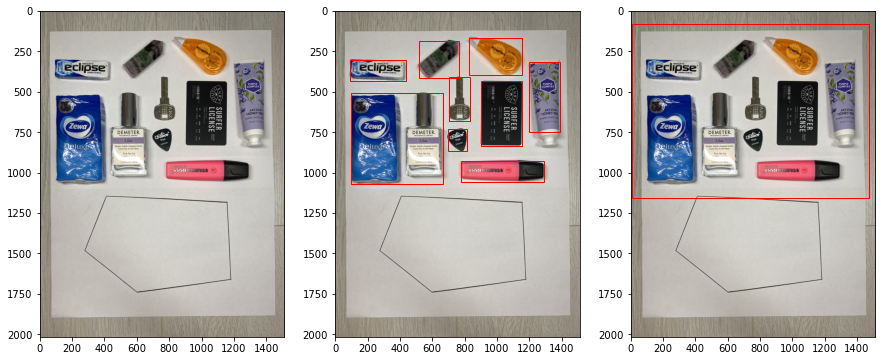

In [11]:
# найдем прямоугольник, ограничивающий все предметы, чтобы вырезать их с изображения
result_boxes = []
labels = measure.label(mask_image)
props = regionprops(labels)

ig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(img)
ax[1].imshow(img)
ax[2].imshow(img)

# заодно удостоверимся, что на изображении нашлись предметы
objects = 0
min_y, min_x, max_y, max_x = img.shape[0], img.shape[1], 0, 0
for prop in props:
    # не учитываем компоненту, образованную столом и тенью
    if prop.area > 5000 and prop.bbox[0] > 50:
        objects += 1
        prop_min_y, prop_min_x, prop_max_y, prop_max_x = prop.bbox
        ax[1].add_patch(patches.Rectangle((prop_min_x, prop_min_y),  prop_max_x - prop_min_x, prop_max_y - prop_min_y, linewidth=1, edgecolor='r', facecolor='none'))
        min_y, min_x, max_y, max_x = min(prop_min_y, min_y), min(prop_min_x, min_x), max(prop_max_y, max_y), max(prop_max_x, max_x)
        
# немного расширяем прямоугольник, чтобы не потерять компоненты предметов, которые не сохранились в маске
min_y, min_x, max_y, max_x = max(min_y - 85, 0), max(min_x - 85, 0), min(max_y + 85, img.shape[1]), min(max_x + 85,  img.shape[0]) 
ax[2].add_patch(patches.Rectangle((min_x, min_y),  max_x - min_x, max_y - min_y, linewidth=1, edgecolor='r', facecolor='none'))
plt.show()
if objects == 0:
    print("Ошибка: объекты не были найдены!")

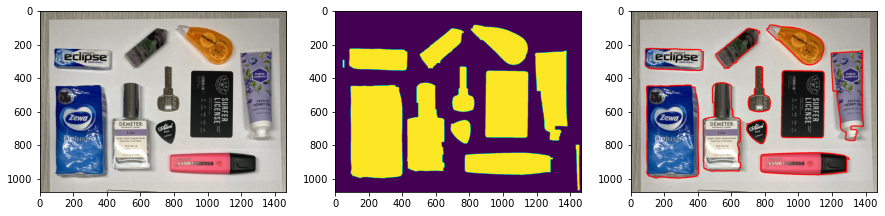

In [12]:
# обрезаем изображение
objects_image = img[min_y:max_y, min_x:max_x]
objects_image_gray = img_blur_gray[min_y:max_y, min_x:max_x]

obj_img = cv2.GaussianBlur(objects_image_gray, (5, 5), 10.)
obj_img = canny(obj_img, 2.2, 0.01, 0.15)
obj_img[:10,:], obj_img[:,:10], obj_img[-10:,:], obj_img[:,-10:] = 0, 0, 0, 0
obj_img = binary_opening(obj_img, footprint=np.ones((1, 1)))
obj_img = binary_closing(obj_img, footprint=np.ones((20, 20)))
obj_img = ndi.binary_fill_holes(obj_img)
obj_img = binary_opening(obj_img, footprint=np.ones((10, 10)))

contours, hierarchy = cv2.findContours(obj_img.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = list(filter(lambda x: cv2.contourArea(x) > 5000, contours))   
# obj_img = cv2.drawContours(obj_img.astype(np.uint8), contours, -1, (255,0,0), cv.FILLED)
img_contour = cv2.drawContours(objects_image.copy(), contours, -1, (255,0,0), 5)

ig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(objects_image)
ax[1].imshow(obj_img)
ax[2].imshow(img_contour)
plt.show()

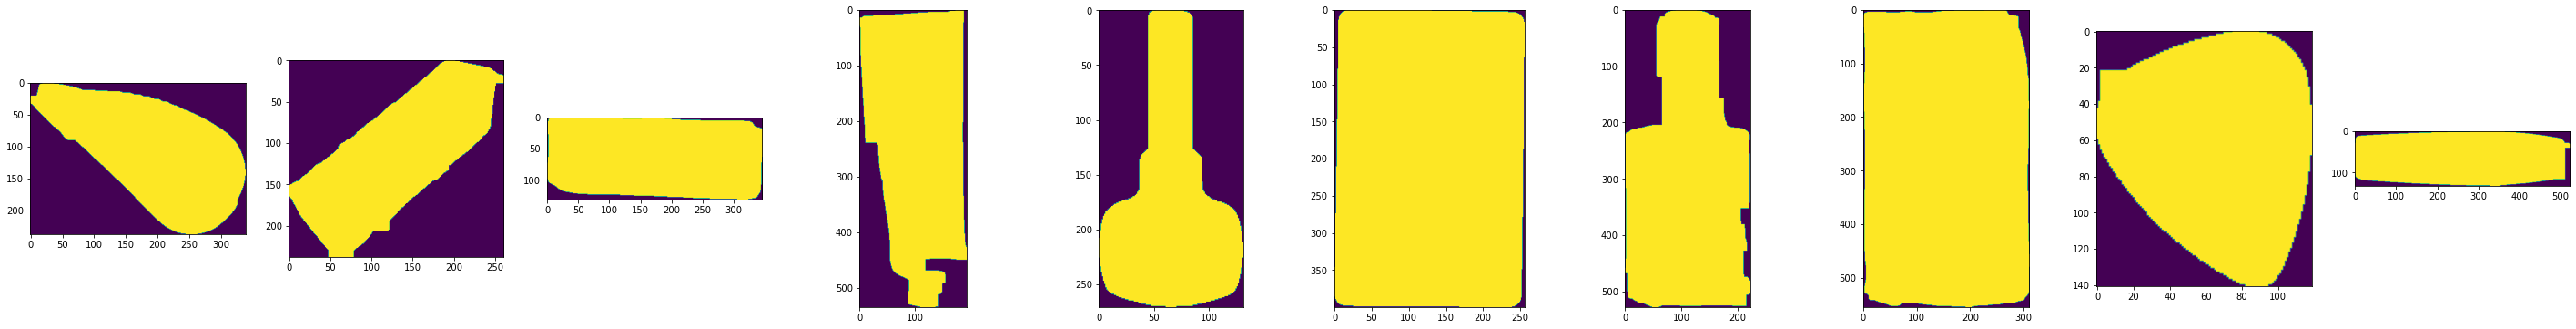

In [13]:
labels = measure.label(obj_img)
props = regionprops(labels)
props = list(filter(lambda x: x.area > 5000, props))   

ig, ax = plt.subplots(1, len(props), figsize=(len(props) * 5, 6))
if len(props) > 1:
    for i, prop in enumerate(props):
        ax[i].imshow(prop.image)
else:
     ax.imshow(prop[0].image)
plt.show()

## Получение маски многоугольника

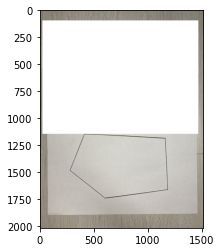

In [15]:
# закрасим область с предметами белым прямоугольником, чтобы они не влияли на поиск многоугольника
working_img = Image.fromarray(img) 
draw = ImageDraw.Draw(working_img)
draw.rectangle((min_x + 15, min_y + 15, max_x - 15, max_y - 15), fill=ImageColor.getrgb("white"))

image_without_objects = np.asarray(working_img)
plt.imshow(image_without_objects)
plt.show()

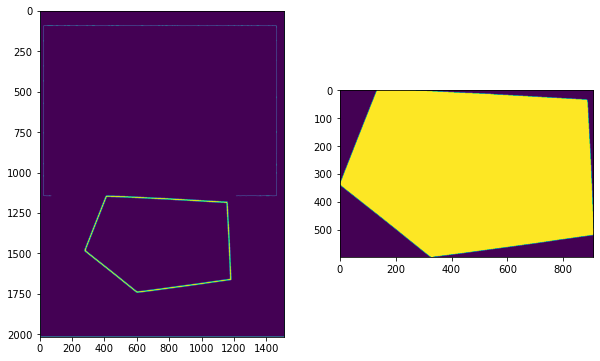

In [16]:
# применим детектор границ Кэнни и морфологические операции
img_blur_gray = rgb2gray(image_without_objects)
edges = canny(img_blur_gray, sigma=3, low_threshold=0.2, high_threshold = 0.3) 
edges = binary_closing(edges, footprint=np.ones((10, 10)))

# выберем компоненту, наибольшую по площади (все остальные - шум, так как мы исключили предметы)
labels = measure.label(edges)
props = regionprops(labels)
area = np.array([p.area for p in props if p.bbox[0] > 0])
# если компонента с наибольшей площадью слишком маленькая, считаем, что многоугольник не найден
if area.max() < 1000:
    print("Ошибка: многоугольник не был найден!")
polygon_id = area.argmax()
polygon_mask = (labels == (polygon_id + 2))
# заполним многоугольник
polygon_mask = ndi.binary_fill_holes(polygon_mask)
labels = measure.label(polygon_mask)
props = regionprops(labels)
# если заполненный многоугольник имеет слишком маленькую площадь  по сравнению с его bbox'ом, 
# считаем, что его граница была незамкнутой
if props[0].area < 0.1 * props[0].image.shape[0] * props[0].image.shape[1]:
    print("Ошибка: граница многоугольника не замкнута!")
    
ig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(edges)
ax[1].imshow(props[0].image)
plt.show()

In [17]:
# оформим полученную послеовательность действий в виде функций и добавим их в библиотеку 
# посмотрим результат работы еще на нескольких тестовых изображениях
from intelligent_placer_lib.modules import detection

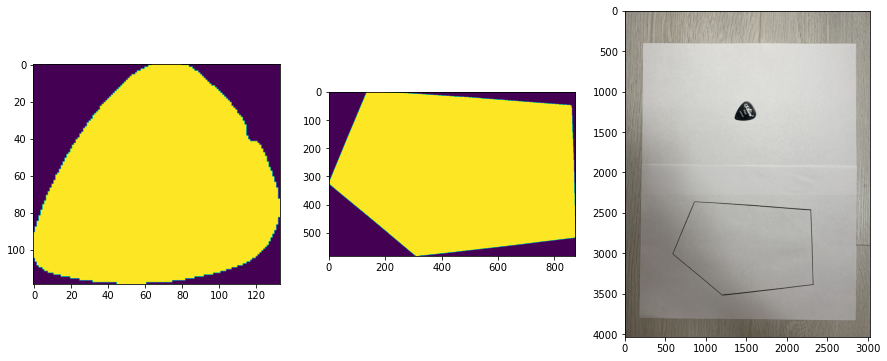

In [18]:
img_path = os.path.join(DATASET_PATH, "1.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
ig, ax = plt.subplots(1, len(objects) + 2, figsize=((len(objects) + 2) * 5, 6))
for i, obj in enumerate(objects):
    ax[i].imshow(obj.image)
ax[len(objects)].imshow(polygon_mask.image)
ax[len(objects) + 1].imshow(imread(img_path))
plt.show()

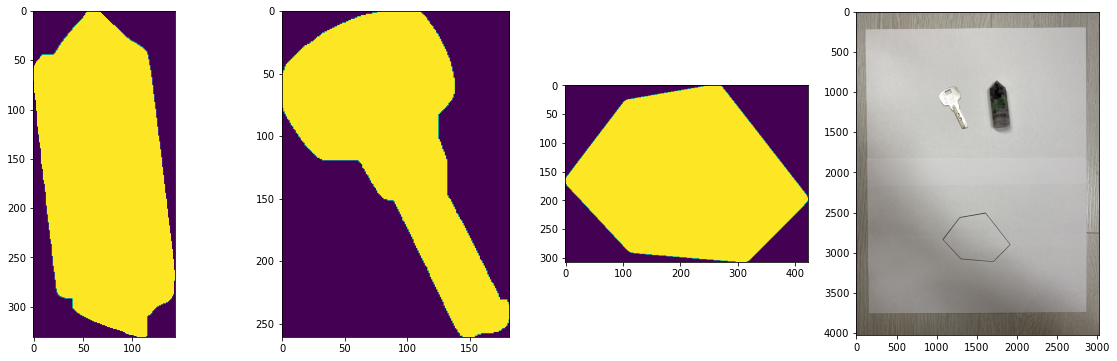

In [19]:
img_path = os.path.join(DATASET_PATH, "8.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
ig, ax = plt.subplots(1, len(objects) + 2, figsize=((len(objects) + 2) * 5, 6))
for i, obj in enumerate(objects):
    ax[i].imshow(obj.image)
ax[len(objects)].imshow(polygon_mask.image)
ax[len(objects) + 1].imshow(imread(img_path))
plt.show()

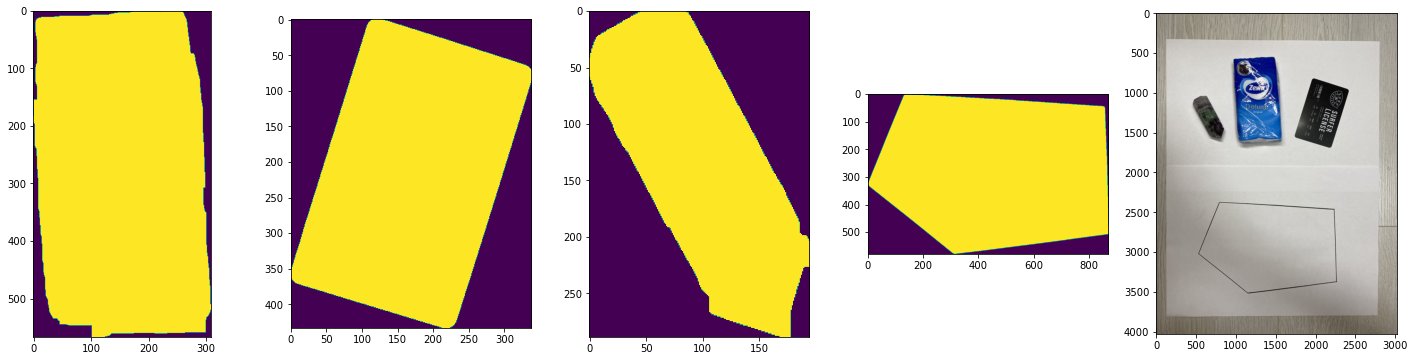

In [20]:
img_path = os.path.join(DATASET_PATH, "18.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
ig, ax = plt.subplots(1, len(objects) + 2, figsize=((len(objects) + 2) * 5, 6))
for i, obj in enumerate(objects):
    ax[i].imshow(obj.image)
ax[len(objects)].imshow(polygon_mask.image)
ax[len(objects) + 1].imshow(imread(img_path))
plt.show()

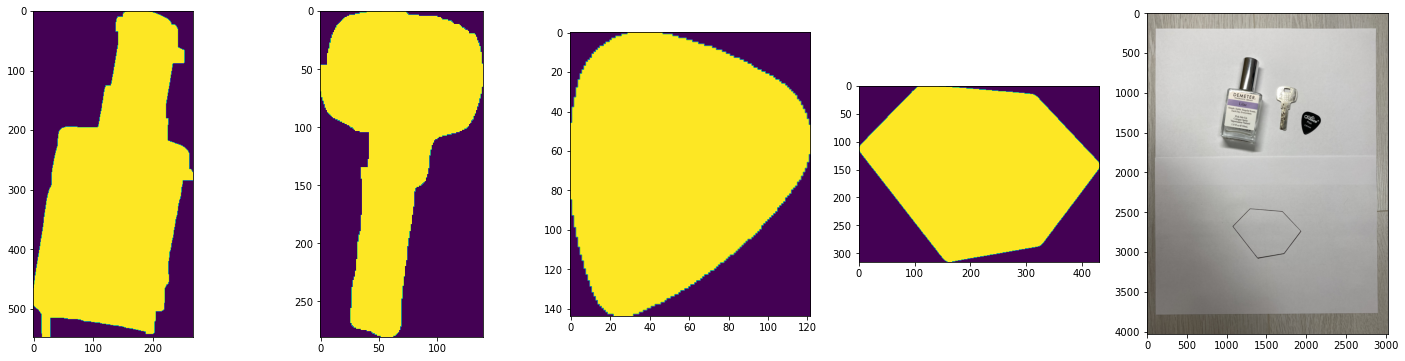

In [21]:
img_path = os.path.join(DATASET_PATH, "28.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
ig, ax = plt.subplots(1, len(objects) + 2, figsize=((len(objects) + 2) * 5, 6))
for i, obj in enumerate(objects):
    ax[i].imshow(obj.image)
ax[len(objects)].imshow(polygon_mask.image)
ax[len(objects) + 1].imshow(imread(img_path))
plt.show()

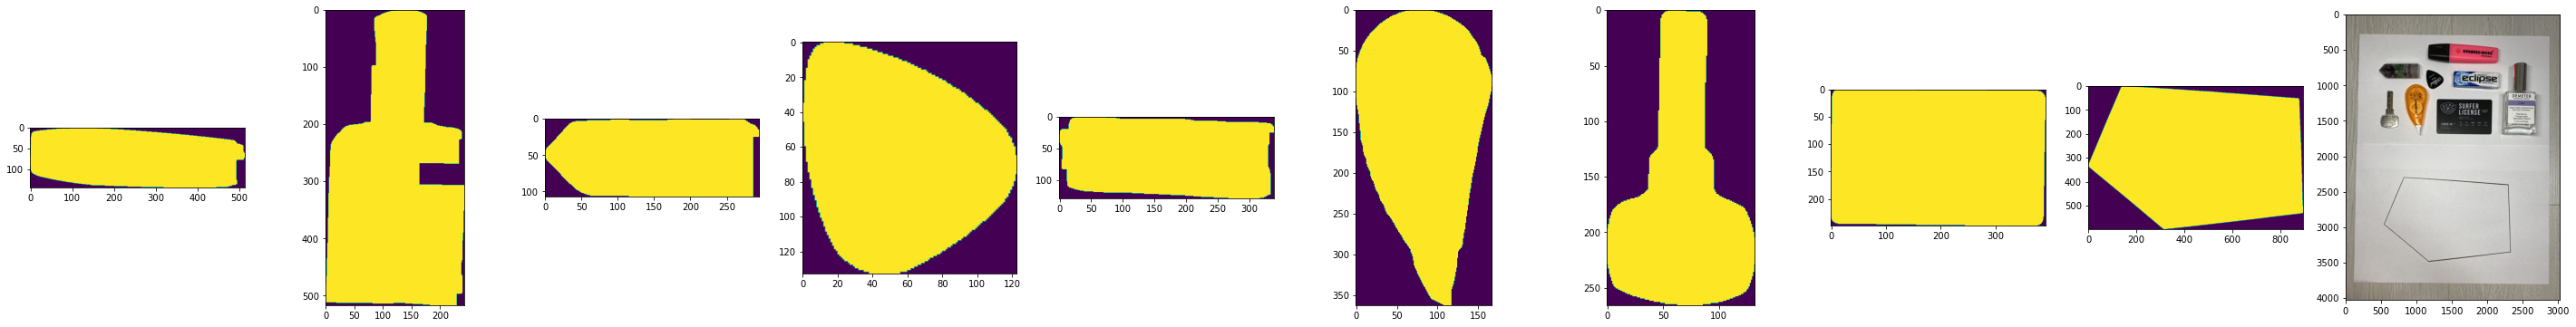

In [22]:
img_path = os.path.join(DATASET_PATH, "24.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
ig, ax = plt.subplots(1, len(objects) + 2, figsize=((len(objects) + 2) * 5, 6))
for i, obj in enumerate(objects):
    ax[i].imshow(obj.image)
ax[len(objects)].imshow(polygon_mask.image)
ax[len(objects) + 1].imshow(imread(img_path))
plt.show()

# Укладка предметов

### Базовые проверки

In [23]:
# проверка на сумму площадей
def check_areas_condition(objects, polygon_mask):
    sum_area = 0
    for obj in objects:
        sum_area += obj.area
    if sum_area > polygon_mask.area:
        return False
    return True

img_path = os.path.join(DATASET_PATH, "28.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
if not check_areas_condition(objects, polygon_mask):
    print("Суммарная площадь предметов больше площади многоугольника")

Суммарная площадь предметов больше площади многоугольника


In [24]:
# проверка на максимальную длину
def check_length_condition(objects, polygon_mask):
    polygon_axis_major_length = polygon_mask.axis_major_length
    for obj in objects:
        if obj.axis_major_length > polygon_axis_major_length:
            return False
    return True
        
img_path = os.path.join(DATASET_PATH, "26.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
if not check_length_condition(objects, polygon_mask):
    print("Длина одного из предметов превышает длину наибольшей диагонали многоугольника")

Длина одного из предметов превышает длину наибольшей диагонали многоугольника


### Алгоритм укладки

In [25]:
def place_one_object(polygon, obj, shift_step=10, angle_step=10):
    obj = obj.astype(int)
    poly_height, poly_width = polygon.shape

    for angle in range(0, 360 - angle_step, angle_step):
        # поворачиваем маску предмета
        rotated_obj = obj.copy()
        rotated_obj = rotate(rotated_obj, angle, reshape=True)
        # обрезаем маску до bbox'а
        idx1, idx2 = np.argwhere(np.all(rotated_obj == 0, axis=0)), np.argwhere(np.all(rotated_obj == 0, axis=1))
        rotated_obj = np.delete(np.delete(rotated_obj, idx1, axis=1), idx2, axis=0)
        obj_height, obj_width = rotated_obj.shape
        
        max_x = poly_height - obj_height
        max_y = poly_width - obj_width
        for x in range(0, max_x, shift_step):
            for y in range(0, max_y, shift_step):
                # расширяем маску объекта до размеров маски многоугольника
                obj_extended = np.zeros_like(polygon)
                obj_extended[x : x + obj_height, y : y + obj_width] = rotated_obj
                # проверяем, поместился ли объект с помощью логического и
                result = cv2.bitwise_and(obj_extended, polygon)
            
                if True not in result:
                    # если размещение удалось, сохраняем новую маску с помощью логического или
                    polygon[x: x + obj_height, y : y + obj_width] = cv2.bitwise_or(rotated_obj, polygon[x: x + obj_height, y : y + obj_width])
                    return True, polygon
    return False, polygon

In [26]:
def place_all_objects(polygon_mask, objects):
    if not check_areas_condition(objects, polygon_mask):
        return False
    if not check_length_condition(objects, polygon_mask):
        return False
    
    # инвертируем маску многоугольника
    placement_mask = cv2.bitwise_not(polygon_mask.image.astype(int))
    # будем размещать предметы в порядке убывания площадей
    objects = sorted(objects, key=lambda x: x.area, reverse=True) 
    for obj in objects:
        res, placement_mask = place_one_object(placement_mask, obj.image)
        if res is False:
            plt.imshow(placement_mask)
            plt.show()
            return False
    plt.imshow(placement_mask)
    plt.show()
    return True

# Примеры работы всего алгоритма IntelligentPlacer'а

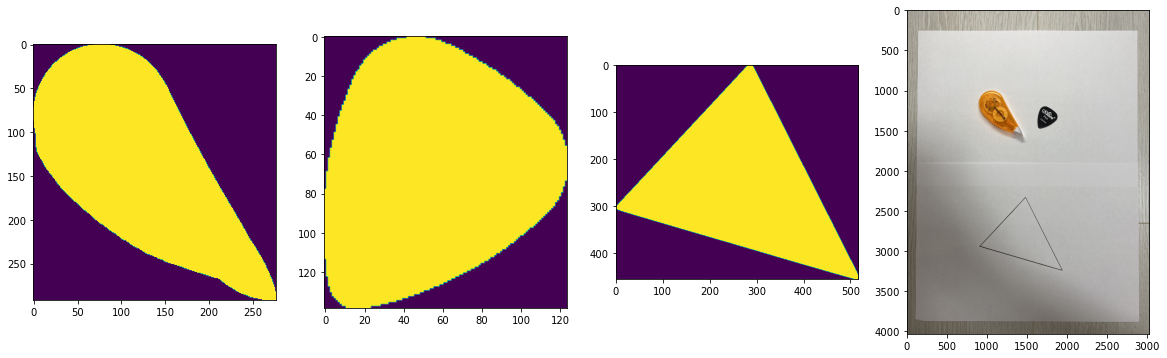

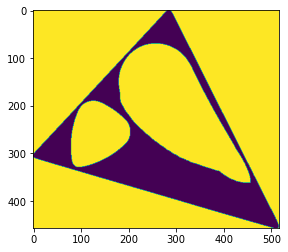

True


In [27]:
# программа выдала верный ответ True
img_path = os.path.join(DATASET_PATH, "16.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)

if objects and polygon_mask:
    ig, ax = plt.subplots(1, len(objects) + 2, figsize=((len(objects) + 2) * 5, 6))
    
    for i, obj in enumerate(objects):
        ax[i].imshow(obj.image)
    ax[len(objects)].imshow(polygon_mask.image)
    ax[len(objects) + 1].imshow(imread(img_path))
    plt.show()

    result = place_all_objects(polygon_mask, objects)
    print(result)
else:
    plt.imshow(imread(img_path))
    plt.show()

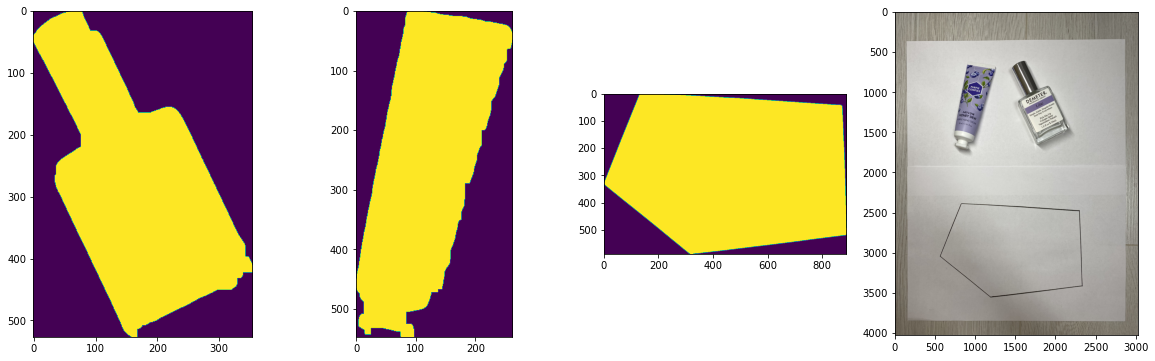

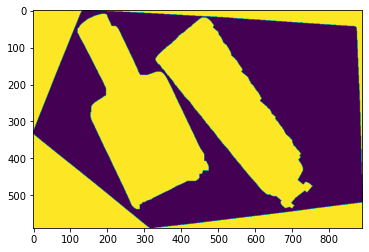

True


In [28]:
# программа выдала верный ответ True
img_path = os.path.join(DATASET_PATH, "2.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)

if objects and polygon_mask:
    ig, ax = plt.subplots(1, len(objects) + 2, figsize=((len(objects) + 2) * 5, 6))
    
    for i, obj in enumerate(objects):
        ax[i].imshow(obj.image)
    ax[len(objects)].imshow(polygon_mask.image)
    ax[len(objects) + 1].imshow(imread(img_path))
    plt.show()

    result = place_all_objects(polygon_mask, objects)
    print(result)
else:
    plt.imshow(imread(img_path))
    plt.show()

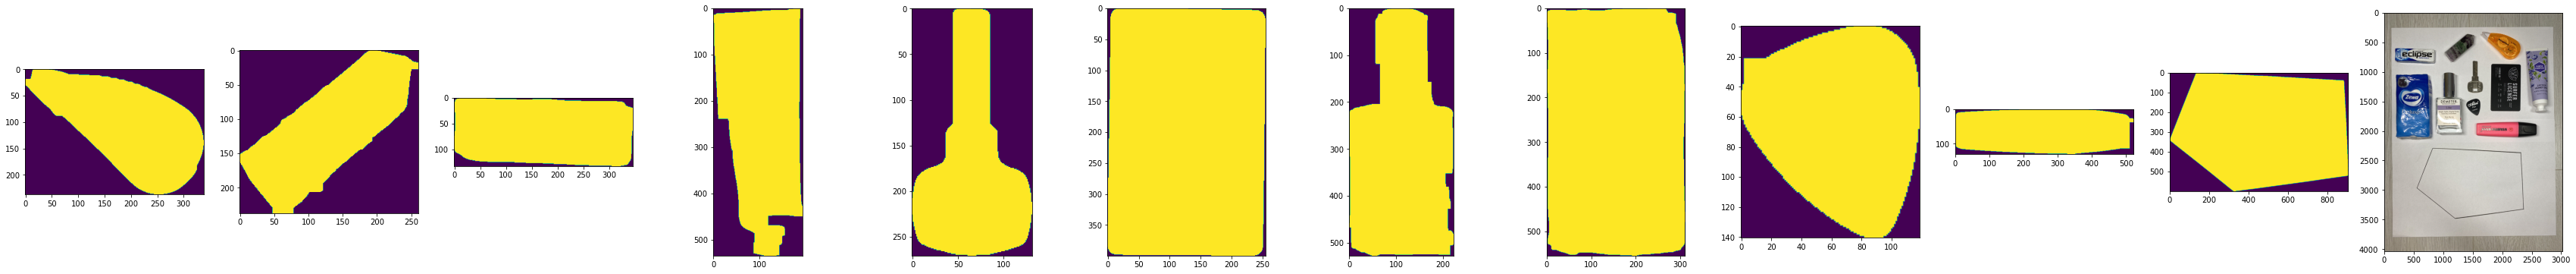

False


In [29]:
# программа выдала верный ответ False, оценив соотношение площадей
img_path = os.path.join(DATASET_PATH, "23.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)

if objects and polygon_mask:
    ig, ax = plt.subplots(1, len(objects) + 2, figsize=((len(objects) + 2) * 5, 6))
    
    for i, obj in enumerate(objects):
        ax[i].imshow(obj.image)
    ax[len(objects)].imshow(polygon_mask.image)
    ax[len(objects) + 1].imshow(imread(img_path))
    plt.show()

    result = place_all_objects(polygon_mask, objects)
    print(result)
else:
    plt.imshow(imread(img_path))
    plt.show()

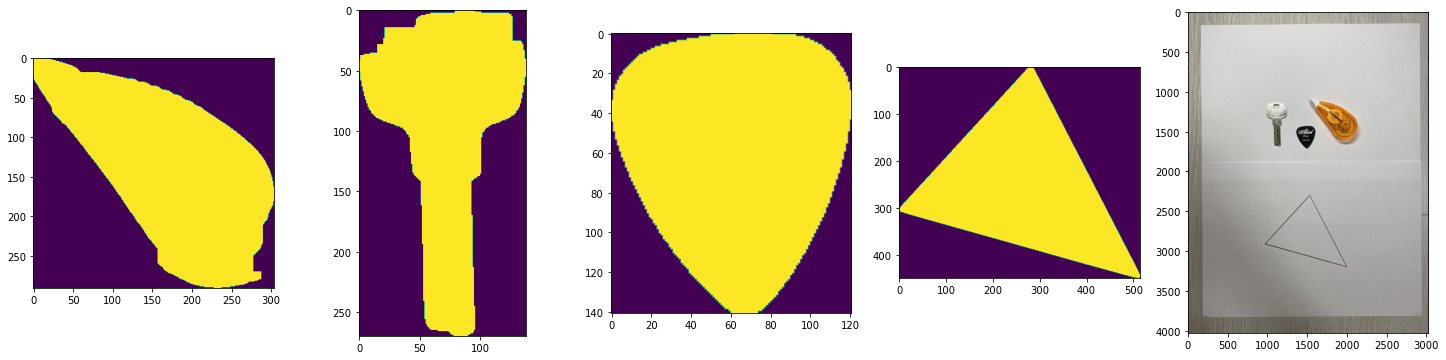

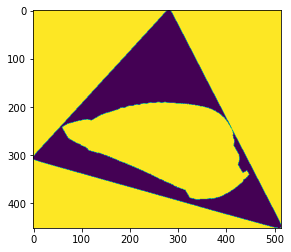

False


In [30]:
# программа выдала верный ответ False, попробовав расположить предметы
img_path = os.path.join(DATASET_PATH, "27.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)

if objects and polygon_mask:
    
    ig, ax = plt.subplots(1, len(objects) + 2, figsize=((len(objects) + 2) * 5, 6))
    for i, obj in enumerate(objects):
        ax[i].imshow(obj.image)
    ax[len(objects)].imshow(polygon_mask.image)
    ax[len(objects) + 1].imshow(imread(img_path))
    plt.show()

    result = place_all_objects(polygon_mask, objects)
    print(result)
else:
    plt.imshow(imread(img_path))
    plt.show()

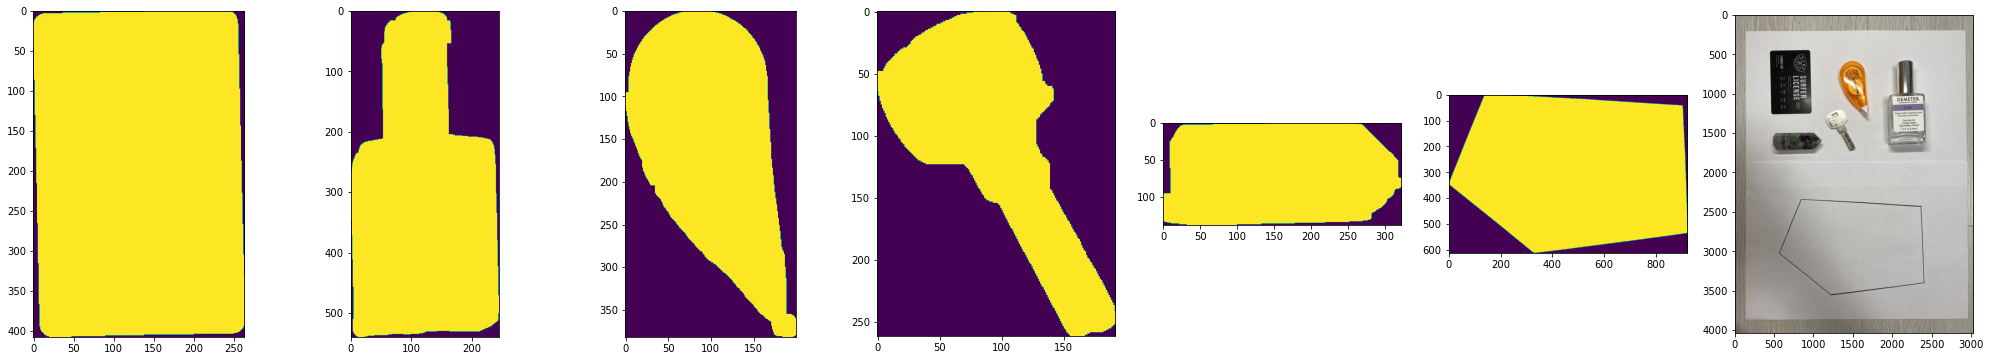

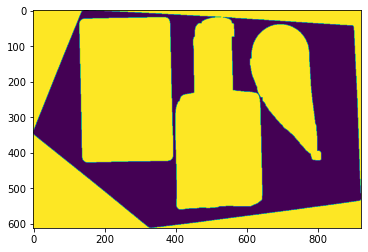

False


In [31]:
# программа выдала неверный ответ False 
# очевидно, в данном случае число возможных расположений предметов внутри многоугольника было очень ограничено, 
# поэтому программа не справилась с верным размещением
img_path = os.path.join(DATASET_PATH, "19.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)

if objects and polygon_mask:
    ig, ax = plt.subplots(1, len(objects) + 2, figsize=((len(objects) + 2) * 5, 6))
    
    for i, obj in enumerate(objects):
        ax[i].imshow(obj.image)
    ax[len(objects)].imshow(polygon_mask.image)
    ax[len(objects) + 1].imshow(imread(img_path))
    plt.show()

    result = place_all_objects(polygon_mask, objects)
    print(result)
else:
    plt.imshow(imread(img_path))
    plt.show()

Результаты работы программы на всем датасете и оценка качества работы алгоритма расположены в файле [algorithm_quality_assessment.ipynb](algorithm_quality_assessment.ipynb).